In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

figsize=(14, 4)

random_state = 42   

from utils.data_visualizator import plot_confusion_matrix

from utils import DataAggregator

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Concatenate
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import MeanSquaredError, SparseCategoricalCrossentropy

from sklearn.preprocessing import StandardScaler

import pandas as pd

tf.random.set_seed(123)

In [2]:
data_aggregator = DataAggregator()

In [3]:
df = data_aggregator.get_data(["E0"])
df = data_aggregator.format_date(df, "Date")
df = data_aggregator.encode_result(df,
                        mapping={"H": 1, "D": 0, "A": -1}, 
                        result_column="FTR")
df = data_aggregator.create_form_data(df, form_window=3)
df = data_aggregator.create_gd_feature(df)
df.drop(columns=["Div", "FTHG", "FTAG", "HTHG", "HTAG", "HTR", "Referee", "HS", "AS", "HST", "AST", "HF", "AF", "HC","AC","HY","AY","HR","AR"], inplace=True)
df = data_aggregator.one_hot_encode_teams(df, "HomeTeam", "AwayTeam")

In [4]:
target = "FTR"
GD_target = "GD"

df_train = df[df["Date"] < "2023-07-01"]
df_test = df[df["Date"] >= "2023-07-01"]
df_test = df_test[df_test["Date"] < "2024-07-01"]

X_train = df_train.drop(columns=[target, "Date", "FTR", GD_target])
y_train = df_train[target]
y_train_gd = df_train[GD_target]
X_test = df_test.drop(columns=[target, "Date", "FTR", GD_target])
y_test = df_test[target]
y_test_gd = df_test[GD_target]

In [5]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
input_dim = X_train.shape[1]

## Classifier
First of all, we start by creating a neural network that will act as a classifier. We will use it to classify the matches into categorical "Win", "Draw" and "Loss".

In [6]:
def create_classifier(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])
    model.name = "classifier"
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
y_train_cls = to_categorical(y_train.map({-1: 0, 0: 1, 1: 2}))
y_test_cls = to_categorical(y_test.map({-1: 0, 0: 1, 1: 2}))

In [8]:
classifier = create_classifier(input_dim)
print(classifier.summary())

Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,835 (34.51 KB)

 Trainable params: 8,835 (34.51 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
history = classifier.fit(X_train, y_train_cls, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4055 - loss: 1.2357 - val_accuracy: 0.5081 - val_loss: 1.0153
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.4919 - loss: 1.0382 - val_accuracy: 0.5113 - val_loss: 1.0054
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.5026 - loss: 1.0099 - val_accuracy: 0.5169 - val_loss: 1.0037
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.5275 - loss: 0.9845 - val_accuracy: 0.5094 - val_loss: 1.0031
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.5309 - loss: 0.9816 - val_accuracy: 0.5182 - val_loss: 0.9994
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.5303 - loss: 0.9711 - val_accuracy: 0.5163 - val_loss: 0.9963
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.5371 - loss: 0.9697 - val_accuracy: 0.5081 - val_loss: 1.0001
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - accuracy: 0.5417 - loss: 0.9575 - va

In [10]:
y_pred_cls = classifier.predict(X_test)
mapped_predictions_cls = y_pred_cls.argmax(axis=1) - 1

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [11]:
cls_df = pd.concat([df_test[[target, "B365H", "B365D", "B365A"]].reset_index(drop=True), pd.Series(mapped_predictions_cls, name="PredictedOutcome")], axis=1)

cls_accuracy, cls_won = data_aggregator.calculate_accuracy(cls_df, target, "PredictedOutcome")

print(f"""The accuracy of the model is {cls_accuracy:.2%}
The accuracy of the model is {cls_accuracy*len(cls_df):.0f} out of {len(cls_df)} games.
""")
print(f"With this model, the expected return on value would be {cls_won:.2f}€")

The accuracy of the model is 54.21%
The accuracy of the model is 206 out of 380 games.

With this model, the expected return on value would be 7385.20€


In [12]:
print(classification_report(y_test, mapped_predictions_cls))

              precision    recall  f1-score   support

          -1       0.61      0.44      0.51       123
           0       0.40      0.07      0.12        82
           1       0.53      0.83      0.65       175

    accuracy                           0.54       380
   macro avg       0.51      0.45      0.43       380
weighted avg       0.53      0.54      0.49       380



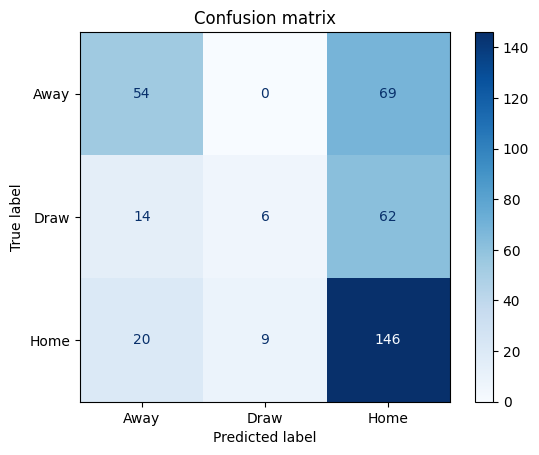

In [13]:
cm = confusion_matrix(y_test, mapped_predictions_cls)
plot_confusion_matrix(cm, ["Away", "Draw", "Home"])

## Regressor
Next up we will define a neural network as a regressor, and will use it to predict the goal difference of a match.

In [14]:
def create_regressor(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.name = "regressor"
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [15]:
regressor = create_regressor(input_dim)
print(regressor.summary())

Model: "regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769 (34.25 KB)

 Trainable params: 8,769 (34.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [16]:
history = regressor.fit(X_train, y_train_gd, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.2429 - mae: 1.3945 - val_loss: 3.0825 - val_mae: 1.3612
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 2.7117 - mae: 1.2734 - val_loss: 3.0640 - val_mae: 1.3567
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 2.5621 - mae: 1.2365 - val_loss: 3.0391 - val_mae: 1.3505
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 2.5084 - mae: 1.2211 - val_loss: 3.0436 - val_mae: 1.3529
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 2.5018 - mae: 1.2235 - val_loss: 3.0370 - val_mae: 1.3515
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 2.4436 - mae: 1.2137 - val_loss: 3.0347 - val_mae: 1.3536
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 2.4018 - mae: 1.2082 - val_loss: 3.0348 - val_mae: 1.3527
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 2.4096 - mae: 1.2026 - val_loss: 3.0317 - val_mae: 1.3533
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s

In [17]:
def map_result(predicitions):
    return [1 if p >= 1 else -1 if p <= -1 else 0 for p in map(round, predicitions)]

y_pred = regressor.predict(X_test).flatten()

mapped_predictions = map_result(y_pred)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [18]:
regr_df = pd.concat([df_test[[target, "B365H", "B365D", "B365A"]].reset_index(drop=True), pd.Series(mapped_predictions, name="PredictedOutcome")], axis=1)

regr_accuracy, regr_won = data_aggregator.calculate_accuracy(regr_df, target, "PredictedOutcome")

print(f"""The accuracy of the model is {regr_accuracy:.2%}
The accuracy of the model is {regr_accuracy*len(regr_df):.0f} out of {len(regr_df)} games.
""")
print(f"With this model, the expected return on value would be {regr_won:.2f}€")

The accuracy of the model is 45.00%
The accuracy of the model is 171 out of 380 games.

With this model, the expected return on value would be 6256.80€


In [19]:
print(classification_report(y_test, mapped_predictions))

              precision    recall  f1-score   support

          -1       0.51      0.27      0.35       123
           0       0.22      0.37      0.28        82
           1       0.60      0.62      0.61       175

    accuracy                           0.45       380
   macro avg       0.44      0.42      0.41       380
weighted avg       0.49      0.45      0.45       380



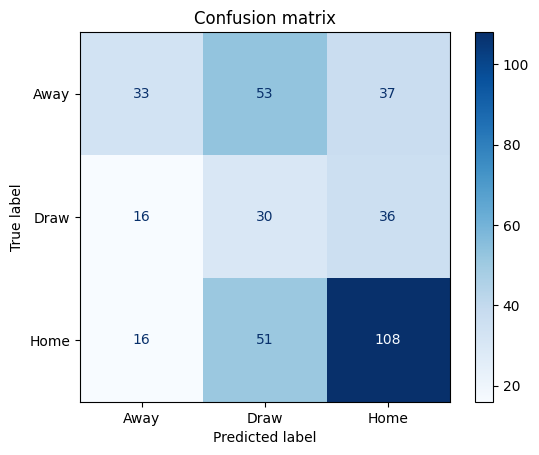

In [20]:
cm = confusion_matrix(y_test, mapped_predictions)
plot_confusion_matrix(cm, ["Away", "Draw", "Home"])

What if we again filter out the predicted draws.

In [21]:
import numpy as np
draw_mask = np.array(mapped_predictions) != 0

regr_df_masked = regr_df[draw_mask]

regr_accuracy_masked, regr_won_masked = data_aggregator.calculate_accuracy(regr_df_masked, target, "PredictedOutcome")

In [22]:
print(f"""The accuracy of the model is {regr_accuracy_masked:.2%}
The accuracy of the model is {regr_accuracy_masked*len(regr_df_masked):.0f} out of {len(regr_df_masked)} games.
""")
print(f"With this model, the expected return on value would be {regr_won_masked:.2f}€")

The accuracy of the model is 57.32%
The accuracy of the model is 141 out of 246 games.

With this model, the expected return on value would be 6687.70€


In [23]:
print("Masked classification repport")
print(classification_report(y_test[draw_mask], regr_df_masked["PredictedOutcome"]))

Masked classification repport
              precision    recall  f1-score   support

          -1       0.51      0.47      0.49        70
           0       0.00      0.00      0.00        52
           1       0.60      0.87      0.71       124

    accuracy                           0.57       246
   macro avg       0.37      0.45      0.40       246
weighted avg       0.45      0.57      0.50       246



/Users/andreasmarken/Desktop/Unibo/AI in Industry/project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andreasmarken/Desktop/Unibo/AI in Industry/project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andreasmarken/Desktop/Unibo/AI in Industry/project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

## Hybrid approach
Finally, we will implement a hybrid variant, where we will take the output of the regressor, i.e., the predicted goal difference, and then use it as a input to a classifier NN in order to predict the results using another NN.

In [24]:
def create_hybrid_model(input_dim):
    inputs = Input(shape=(input_dim,), name="main_input")
    
    regressor = Dense(64, activation="relu", name="regressor_hidden_1")(inputs)
    regressor = Dropout(0.2)(regressor)
    regressor = Dense(32, activation="relu", name="regressor_hidden_2")(regressor)
    gd_output = Dense(1, activation="linear", name="goal_difference_output")(regressor)  # Regression output

    concatenated = Concatenate(name="concat_layer")([inputs, gd_output])
    
    classifier = Dense(64, activation="relu", name="classifier_hidden_1")(concatenated)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(32, activation="relu", name="classifier_hidden_2")(classifier)
    outcome_output = Dense(3, activation="softmax", name="match_outcome_output")(classifier)  # Classification output

    model = Model(inputs=inputs, outputs=[gd_output, outcome_output])

    model.name = "hybrid_model"

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={
            "goal_difference_output": MeanSquaredError(),
            "match_outcome_output": SparseCategoricalCrossentropy()
        },
        metrics={
            "goal_difference_output": "mae",
            "match_outcome_output": "accuracy"
        }
    )
    return model

In [25]:
hybrid_model = create_hybrid_model(input_dim)
print(hybrid_model.summary())

Model: "hybrid_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 103)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regressor_hidden_1  │ (None, 64)        │      6,656 │ main_input[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ regressor_hidden… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regressor_hidden_2  │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ goal_difference_ou… │ (None, 1)         │         33 │ regressor_hidden… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, 104)       │          0 │ main_input[0][0], │
│ (Concatenate)       │                   │            │ goal_difference_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_hidden_1 │ (None, 64)        │      6,720 │ concat_layer[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ classifier_hidde… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_hidden_2 │ (None, 32)        │      2,080 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ match_outcome_outp… │ (None, 3)         │         99 │ classifier_hidde… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,668 (69.02 KB)

 Trainable params: 17,668 (69.02 KB)

 Non-trainable params: 0 (0.00 B)

None


In [26]:
history = hybrid_model.fit(
    X_train,
    {"goal_difference_output": y_train_gd, "match_outcome_output": y_train.map({-1: 0, 0: 1, 1: 2})},
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - goal_difference_output_loss: 3.0138 - goal_difference_output_mae: 1.3374 - loss: 4.1083 - match_outcome_output_accuracy: 0.4374 - match_outcome_output_loss: 1.0945 - val_goal_difference_output_loss: 3.2170 - val_goal_difference_output_mae: 1.3896 - val_loss: 4.2282 - val_match_outcome_output_accuracy: 0.5088 - val_match_outcome_output_loss: 1.0107
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - goal_difference_output_loss: 2.5708 - goal_difference_output_mae: 1.2467 - loss: 3.5503 - match_outcome_output_accuracy: 0.5270 - match_outcome_output_loss: 0.9796 - val_goal_difference_output_loss: 3.1383 - val_goal_difference_output_mae: 1.3714 - val_loss: 4.1403 - val_match_outcome_output_accuracy: 0.5138 - val_match_outcome_output_loss: 1.0014
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - goal_difference_output_loss: 2.5089 - goal_difference_output_mae: 1.2332 - loss: 3.4741 - match_outcome_output_accuracy: 0.5386 - match_ou

In [27]:
y_pred_gd, y_pred_cls = hybrid_model.predict(X_test)

mapped_predictions_gd = map_result(y_pred_gd.flatten())
mapped_predictions_cls = y_pred_cls.argmax(axis=1) - 1

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [28]:
regr_accuracy, regr_won = data_aggregator.calculate_accuracy(regr_df, target, "PredictedOutcome")
print("Regression predictions:")
print(f"""The accuracy of the model is {regr_accuracy:.2%}
The accuracy of the model is {regr_accuracy*len(regr_df):.0f} out of {len(regr_df)} games.
""")
print(f"With this model, the expected return on value would be {regr_won:.2f}€")

Regression predictions:
The accuracy of the model is 45.00%
The accuracy of the model is 171 out of 380 games.

With this model, the expected return on value would be 6256.80€


In [29]:
cls_accuracy, cls_won = data_aggregator.calculate_accuracy(cls_df, target, "PredictedOutcome")
print("Classification predictions:")
print(f"""The accuracy of the model is {cls_accuracy:.2%}
The accuracy of the model is {cls_accuracy*len(cls_df):.0f} out of {len(cls_df)} games.
""")
print(f"With this model, the expected return on value would be {cls_won:.2f}€")

Classification predictions:
The accuracy of the model is 54.21%
The accuracy of the model is 206 out of 380 games.

With this model, the expected return on value would be 7385.20€


Well, as we can see from the output above, the model actually just ignores the predicted goal difference feature. Meaning that the dataset itself is good enough to predict the matches with approx 62% accuracy. In order to achieve better result, we should append more features, and maybe include more form data such as 3 game form, 5 game form, 10 game form, the form against a similar opponent previous...

In [30]:
data_aggregator.save_metrics("nn_cls", cls_accuracy, cls_won)
data_aggregator.save_metrics("nn_regr", regr_accuracy, regr_won)